In [1]:
from sklearn.datasets import make_regression
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
from cvxopt import matrix
from cvxopt import solvers
from numpy import linalg as LA

## Kernelized ridge regression

For training set $X \in \mathbb{R}^{m \times n}$, the primal problem of ridge regression is:

$$ \min_{w}  \frac{1}{2} (y-Xw)^T(y-Xw) + \frac{\lambda}{2} ||w||^2$$

Take the derivative of the loss function $J(w)$ w.r.t $w$ and set it to $0$:

$$\frac{\partial J(w)}{\partial w} = (y-Xw)(-X) + \lambda w = 0$$

Rearranging the above terms, we have:

$$w = (X^TX + \lambda I)^{-1}X^Ty$$

Applying matrix inversion lemma, we have:

$$w = X^T(XX^T + \lambda I)^{-1}y$$

Define the dual parameter $\alpha \in \mathbb{R}^m$ as:

$$\alpha = (XX^T + \lambda I)^{-1}y$$

The relationship between the primal and the dual parameter (Representer Theorem):

$$w = X^T\alpha$$

To make a prediction on a test point x:

$$\hat{y} = xX^T\alpha$$

To kernalize ridge regression, replace $XX^T$ with $K$ where $K_{ij} = k(x_i, x_j) = \phi(x_i)^T \phi(x_j)$:

$$\alpha = (K + \lambda I)^{-1}y$$

To make a prediction on a test point x:

$$\hat{y} = \sum_{i=1}^m k(x, X_i)\alpha_i$$

In [2]:
def gaussian_kernel(x1, x2, sigma=0.1):
    return np.exp(-LA.norm(x1-x2, axis=-1)**2 / (2*sigma**2))

def poly_kernel(x1, x2, degree=3, r=2, gamma=1):
    return (np.dot(x1.T, x2) * gamma + r) ** degree

def laplacian_kernel(x1, x2, sigma=0.1):
    return np.exp(-LA.norm(x1-x2, axis=-1, ord=1) / sigma)

In [3]:
class kernel_ridge_regression:
    def __init__(self, kernel="rbf", sigma=0.1, degree=3, r=2, gamma=1):
        self.kernel = kernel
        self.sigma = sigma
        self.degree = degree
        self.r = r
        self.gamma = gamma
        
    def _kernel_function(self, x1, x2):
        if self.kernel == "rbf":
            return gaussian_kernel(x1, x2, self.sigma)
        elif self.kernel == "poly":
            return poly_kernel(x1, x2, self.degree, self.r, self.gamma)
        elif self.kernel == "laplacian":
            return laplacian_kernel(x1, x2, self.sigma)
        elif self.kernel == "linear":
            return np.dot(x1, x2)
        else:
            print("undefined kernel")
    
    def _get_gram_matrix(self, X_train):
        m,n = X_train.shape
        K = np.zeros((m, m))
        for i, x_i in enumerate(X_train):
            for j, x_j in enumerate(X_train):
                K[i, j] = self._kernel_function(x_i, x_j)
        return K
    
    def fit(self, X_train, y_train, lamb=0.2):
        m,n = X_train.shape
        K = self._get_gram_matrix(X_train)
        alphas = np.dot(LA.inv(K + lamb*np.eye(m)), y_train)
        self.alphas = alphas
        self.X_train = X_train
        
    def predict(self, X_test):
        m,n = self.X_train.shape
        pred_mtx = np.zeros(m)
        pred = []
        for x in X_test:
            for i in range(m):
                pred_mtx[i] = self._kernel_function(x, self.X_train[i, :])
            pred.append(np.sum(self.alphas * pred_mtx))
        return np.array(pred)

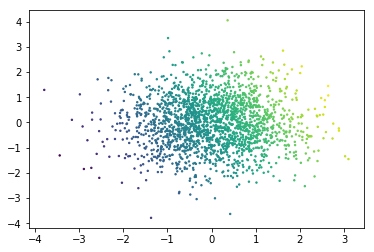

In [4]:
X, y = make_regression(n_samples=2000, n_features=2, noise=0.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=2)
seed = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [5]:
reg = kernel_ridge_regression(kernel="rbf")
reg.fit(X_train, y_train)

In [6]:
pred = reg.predict(X_test)

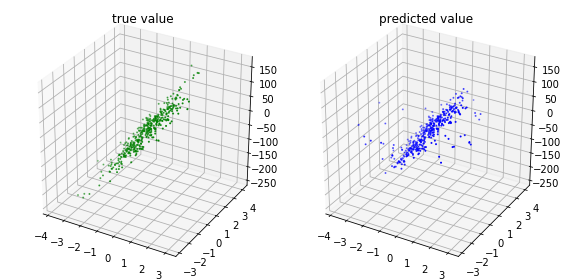

In [7]:
fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(X_test[:, 0], X_test[:, 1], y_test, marker='o', s=1, c="green")
ax.set_zlim([np.min(y_test)-10, np.max(y_test)+10])
plt.title("true value")
ax = fig.add_subplot(122, projection='3d')
ax.scatter(X_test[:, 0], X_test[:, 1], pred, marker='o', s=1, c="blue")
ax.set_zlim([np.min(y_test)-10, np.max(y_test)+10])
plt.title("predicted value")
plt.tight_layout()
plt.show()

## Proof of matrix inversion lemma

First, start with $\lambda X^T = \lambda X^T$. Then left multiply LHS and right multiply the RHS:

$$\lambda I_n X^T = \lambda X^T I_m$$

Add $X^TXX^T$ to both sides:

$$X^TXX^T + \lambda I_n X^T = X^TXX^T + \lambda X^T I_m$$

Applying distributive property:

$$(X^TX + \lambda I_n)X^T = X^T(XX^T + \lambda I_m)$$

Left multiply $(X^TX + \lambda I_n)^{-1}$ and right multiply $(XX^T + \lambda I_m)^{-1}$ for both sides:

$$(X^TX + \lambda I_n)^{-1} (X^TX + \lambda I_n)X^T (XX^T + \lambda I_m)^{-1}= (X^TX + \lambda I_n)^{-1} X^T(XX^T + \lambda I_m) (XX^T + \lambda I_m)^{-1}$$

$$X^T (XX^T + \lambda I_m)^{-1} = (X^TX + \lambda I_n)^{-1} X^T$$